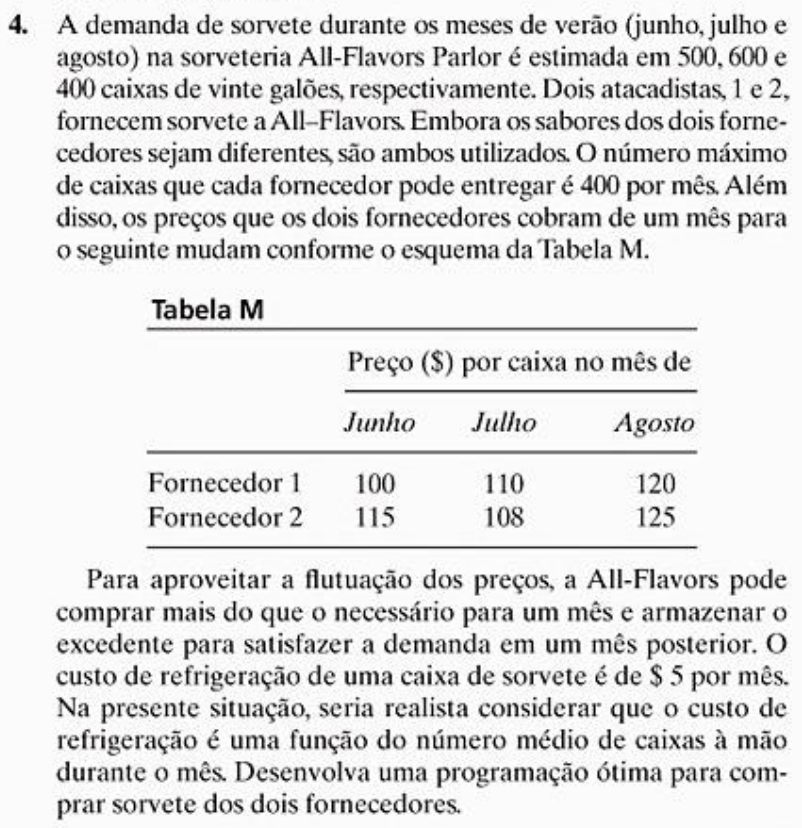

In [1]:
%pip install cplex
%pip install docplex

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from docplex.mp.model import Model

# Criação do modelo com um nome descritivo
model = Model('Planejamento_Compras_Sorveteria')

In [3]:
# --- Parâmetros extraídos do enunciado ---

# Períodos de tempo e fornecedores
meses = ['junho', 'julho', 'agosto']
fornecedores = [1, 2]

# Demanda mensal (em caixas)
demanda_mensal = {'junho': 500, 'julho': 600, 'agosto': 400}

# Custos de compra ($ por caixa)
# Estrutura: custo_compra[fornecedor][mes]
custo_compra = {
    1: {'junho': 100, 'julho': 110, 'agosto': 120},
    2: {'junho': 115, 'julho': 108, 'agosto': 125}
}

# Custo de refrigeração (estoque)
custo_estoque_por_caixa_mes = 5

# Limites
limite_fornecedor_por_mes = 400 # caixas

In [4]:
# 1. Variáveis de Decisão
# Quantidade de caixas compradas de cada fornecedor em cada mês
compras = model.continuous_var_matrix(fornecedores, meses, name='Compra')

# Quantidade de caixas em estoque no final de cada mês
estoque_final = model.continuous_var_dict(meses, name='Estoque', lb=0)


# 2. Função Objetivo
# Minimizar o custo total (Compras + Estoque)
expressao_custo_compra = (custo_compra[f][m] * compras[f,m] for f in fornecedores for m in meses)
soma_custo_compra = model.sum(expressao_custo_compra)

expressao_custo_estoque = (custo_estoque_por_caixa_mes * estoque_final[m] for m in meses)
soma_custo_estoque = model.sum(expressao_custo_estoque)

custo_total = soma_custo_compra + soma_custo_estoque
model.minimize(custo_total)


# 3. Restrições

# Restrição 1: Balanço de Estoque para cada mês
# Estoque_Inicial + Compras_do_Mês - Demanda_do_Mês = Estoque_Final
for idx, m in enumerate(meses):
    estoque_inicial_mes = estoque_final[meses[idx-1]] if idx > 0 else 0
    compras_no_mes = model.sum(compras[f,m] for f in fornecedores)
    
    restr_balanco_logica = estoque_inicial_mes + compras_no_mes - demanda_mensal[m] == estoque_final[m]
    model.add_constraint(restr_balanco_logica, ctname=f'balanco_{m}')

# Restrição 2: Limite de Compra por Fornecedor
for f in fornecedores:
    for m in meses:
        restr_limite_logica = compras[f,m] <= limite_fornecedor_por_mes
        model.add_constraint(restr_limite_logica, ctname=f'limite_f{f}_{m}')

In [5]:
# Define um tempo limite para o solver (opcional)
model.parameters.timelimit = 120

# Aciona o solver para encontrar a solução
print("--- Resolvendo o modelo ---")
solucao = model.solve(log_output=True)

print('\n------ SOLUÇÃO ÓTIMA ------\n')
custo_minimo = model.objective_value
print(f"Custo Total Mínimo para o Verão: ${custo_minimo:,.2f}\n")

print("--- Plano de Compras (caixas por mês) ---")
for m in meses:
    print(f"Mês de {m.capitalize()}:")
    for f in fornecedores:
        compra_val = compras[f,m].solution_value
        if compra_val > 1e-6:
            print(f"  - Fornecedor {f}: {compra_val:,.2f} caixas")

print("\n--- Nível de Estoque (caixas no final do mês) ---")
for m in meses:
    estoque_val = estoque_final[m].solution_value
    print(f"  - Final de {m.capitalize()}: {estoque_val:,.2f} caixas")

--- Resolvendo o modelo ---
Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               120
Tried aggregator 1 time.
LP Presolve eliminated 6 rows and 1 columns.
Aggregator did 1 substitutions.
Reduced LP has 2 rows, 7 columns, and 8 nonzeros.
Presolve time = 0.00 sec. (0.01 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =        116700.000000

------ SOLUÇÃO ÓTIMA ------

Custo Total Mínimo para o Verão: $163,700.00

--- Plano de Compras (caixas por mês) ---
Mês de Junho:
  - Fornecedor 1: 400.00 caixas
  - Fornecedor 2: 100.00 caixas
Mês de Julho:
  - Fornecedor 1: 400.00 caixas
  - Fornecedor 2: 400.00 caixas
Mês de Agosto:
  - Fornecedor 1: 200.00 caixas

--- Nível de Estoque (caixas no final do mês) ---
  - Final de Junho: 0.00 caixas
  - Final de Julho: 200.00 caixas
  - Final de Agosto: 0.00 caixas
